# 1

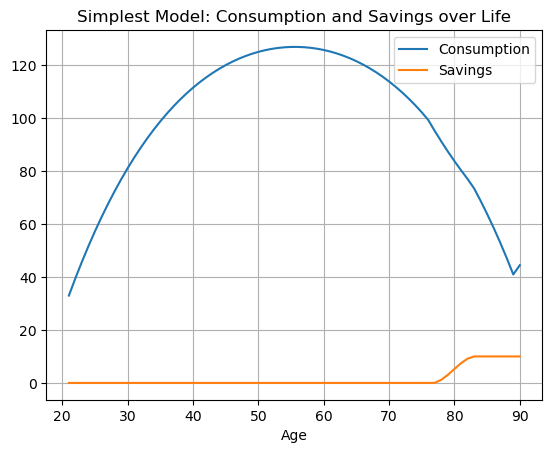

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
A = 70                     # Life periods (age 21 to 90)
r = 0.04                   # Interest rate
β = 0.93                   # Discount factor
w = 1.0                    # Wage level (scalar, so eaw = ea)
s_grid = np.linspace(0, 10, 200)  # Savings grid

# Preferences
def u(c):
    return np.log(np.maximum(c, 1e-10))  # Avoid log(0)

# Labor income function ea = 38.6 + 8.3a − 0.12a²
def ea(a):
    return 38.6 + 8.3 * a - 0.12 * a**2

# Tax rate τ(e) = 0.103 + 0.0011e
def tau(e):
    return 0.103 + 0.0011 * e

# Initialize value and policy functions
V = [np.zeros_like(s_grid) for _ in range(A)]
policy_s = [np.zeros_like(s_grid) for _ in range(A)]

# Last period: consume all
a = A - 1
e = ea(a)
τ = tau(e)
for i, s in enumerate(s_grid):
    c = (1 + r) * s
    V[a][i] = u(c)

# Backward induction
for a in reversed(range(A - 1)):
    e = ea(a)
    τ = tau(e)
    V_next = interp1d(s_grid, V[a + 1], fill_value="extrapolate")

    for i, s in enumerate(s_grid):
        def obj(s_next):
            c = e * w + (1 + r) * s - s_next - τ * e * w - τ * r * s
            return u(c) + β * V_next(s_next)

        s_next_options = s_grid[s_grid >= 0]
        values = np.array([obj(s_next) for s_next in s_next_options])
        best_i = np.argmax(values)

        V[a][i] = values[best_i]
        policy_s[a][i] = s_next_options[best_i]

# Simulate consumption/savings path
s_path = np.zeros(A)
c_path = np.zeros(A)
s = 0
for a in range(A):
    e = ea(a)
    τ = tau(e)
    V_a = interp1d(s_grid, policy_s[a], fill_value="extrapolate")
    s_next = V_a(s)
    c = e * w + (1 + r) * s - s_next - τ * e * w - τ * r * s
    s_path[a] = s
    c_path[a] = c
    s = max(s_next, 0)

# Plot results
plt.plot(range(21, 91), c_path, label='Consumption')
plt.plot(range(21, 91), s_path, label='Savings')
plt.xlabel('Age')
plt.legend()
plt.title('Simplest Model: Consumption and Savings over Life')
plt.grid(True)
plt.show()


# 2

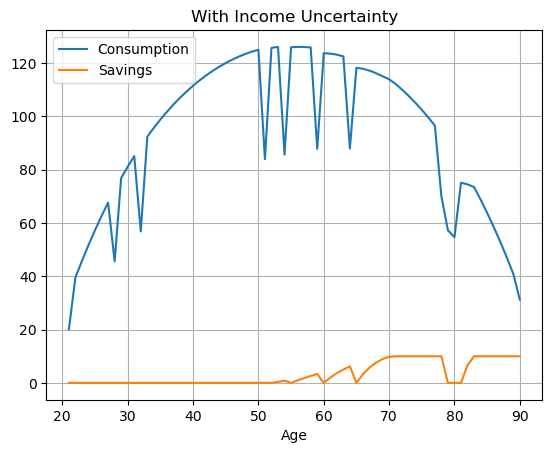

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Parameters
A = 70                     # Periods (age 21–90)
r = 0.04                   # Interest rate
β = 0.93                   # Discount factor
w = 1.0                    # Wage level
s_grid = np.linspace(0, 10, 200)  # Savings grid

# Income shocks
Z = [0, 1]                 # 0 = bad, 1 = good
Π = np.array([[0.30, 0.70],
              [0.10, 0.90]])  # Rows: z, Cols: z'

# Utility
def u(c):
    return np.log(np.maximum(c, 1e-10))

# Age-dependent income
def ea(a): return 38.6 + 8.3 * a - 0.12 * a**2
def eaz(a, z): return (0.6 if z == 0 else 1.0) * ea(a)

# Tax function
def tau(e): return 0.103 + 0.0011 * e

# Initialize value and policy functions: V[a][z][i]
V = [[np.zeros_like(s_grid) for z in Z] for _ in range(A)]
policy_s = [[np.zeros_like(s_grid) for z in Z] for _ in range(A)]

# Terminal period (consume everything)
for z in Z:
    a = A - 1
    for i, s in enumerate(s_grid):
        c = (1 + r) * s
        V[a][z][i] = u(c)

# Backward induction
for a in reversed(range(A - 1)):
    for z in Z:
        e = eaz(a, z)
        τ = tau(e)

        # Interpolated future value for both shocks
        V_next = [interp1d(s_grid, V[a + 1][zp], fill_value='extrapolate') for zp in Z]

        for i, s in enumerate(s_grid):
            def obj(s_next):
                c = e * w + (1 + r) * s - s_next - τ * e * w - τ * r * s
                EV = sum(Π[z, zp] * V_next[zp](s_next) for zp in Z)
                return u(c) + β * EV

            s_options = s_grid[s_grid >= 0]
            values = np.array([obj(s_next) for s_next in s_options])
            best_i = np.argmax(values)

            V[a][z][i] = values[best_i]
            policy_s[a][z][i] = s_options[best_i]

# Simulate sample path
np.random.seed(42)
z_path = np.zeros(A, dtype=int)
s_path = np.zeros(A)
c_path = np.zeros(A)
s = 0

for a in range(A):
    z = z_path[a]
    e = eaz(a, z)
    τ = tau(e)

    s_policy = interp1d(s_grid, policy_s[a][z], fill_value='extrapolate')
    s_next = s_policy(s)
    c = e * w + (1 + r) * s - s_next - τ * e * w - τ * r * s

    s_path[a] = s
    c_path[a] = c
    s = max(s_next, 0)

    if a < A - 1:
        probs = Π[z]
        z_path[a + 1] = np.random.choice(Z, p=probs)

# Plot results
plt.plot(range(21, 91), c_path, label='Consumption')
plt.plot(range(21, 91), s_path, label='Savings')
plt.xlabel('Age')
plt.title('With Income Uncertainty')
plt.grid(True)
plt.legend()
plt.show()


# 3

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

# Parameters
A = 70
r = 0.04
β = 0.93
w = 1.0
Z = [0, 1]
Π = np.array([[0.30, 0.70], [0.10, 0.90]])

# Grids
s_grid = np.linspace(0, 20, 50)
B_grid = np.linspace(0, 500, 50)  # Roth IRA grid
R_contrib_cap = 7

# Functions
def u(c): return np.log(np.maximum(c, 1e-10))
def ea(a): return 38.6 + 8.3 * a - 0.12 * a**2
def eaz(a, z): return (0.6 if z == 0 else 1.0) * ea(a)
def tau(e): return 0.103 + 0.0011 * e

# Initialize value and policy functions
V = [[np.zeros((len(s_grid), len(B_grid))) for z in Z] for _ in range(A)]
policy_s = [[np.zeros_like(V[0][0]) for z in Z] for _ in range(A)]
policy_R = [[np.zeros_like(V[0][0]) for z in Z] for _ in range(A)]

# Terminal condition (consume all s, Roth is leftover)
for z in Z:
    for i, s in enumerate(s_grid):
        for j, B in enumerate(B_grid):
            c = (1 + r) * s + B  # assume all is consumed
            V[-1][z][i, j] = u(c)

# Backward induction
for a in reversed(range(A - 1)):
    for z in Z:
        e = eaz(a, z)
        τ = tau(e)

        # Interpolators for both future z' values
        V_next = [RegularGridInterpolator((s_grid, B_grid), V[a + 1][zp], bounds_error=False, fill_value=None) for zp in Z]

        for i, s in enumerate(s_grid):
            for j, B in enumerate(B_grid):
                best_val = -np.inf
                best_s_next, best_R = 0, 0

                # Contribution limits
                R_min = -B if a >= 45 else 0
                R_options = np.linspace(R_min, R_contrib_cap, 20)

                for R in R_options:
                    for s_next in s_grid:
                        if s_next < 0:
                            continue

                        B_next = B * (1 + r) + R
                        c = e * w + (1 + r) * s - s_next - τ * e * w - τ * r * s - R

                        if c <= 0:
                            continue

                        # Expected value over z'
                        EV = sum(Π[z, zp] * V_next[zp]([[s_next, B_next]])[0] for zp in Z)
                        val = u(c) + β * EV

                        if val > best_val:
                            best_val = val
                            best_s_next = s_next
                            best_R = R

                V[a][z][i, j] = best_val
                policy_s[a][z][i, j] = best_s_next
                policy_R[a][z][i, j] = best_R


KeyboardInterrupt: 